## ------------------------------------
# Hierarchical Clustering Analysis
## ------------------------------------


#### Author: Enrico Gavagnin 
11.08.2022

In this notebook we perform the Hierarchical Clustering Analysis (HCA) on the pool of artificial experimental nests (see Section ?? of the Materials and Methods). 

Notation:
* DEH: Degree heterogeneity
* MOD: Modularity
* DIA: Diameter
* CLS: Clustering
* DEN: Density
* MESH: Meshedness

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import sys
import matplotlib.pyplot as plt
import dask.dataframe as dd
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import seaborn as sns

In [2]:
# Parameters
# Type of nest pool
name = '14es'

# Metric used to calculate distance between properties and clusters of properties (Pearson Correlation)
metric = 'pearson'

# Linkage method to compute the distance between clusters of properties (Average)
method = 'average' 


## Data preparation
Standardisation fo properties and computation of linkage matrix


In [13]:
# Read dataframe of nest properties
df_P = dd.read_csv(name + '/df_P_ja/df_P_*.csv').set_index('G6').drop(['entrance_centrality', 'entrance_degree'], axis=1)

# Standardisation properties (all properties between [0,1])
df_P_min = df_P.min().compute()
df_P_max = df_P.max().compute()
df_P = ((df_P - df_P_min) / (df_P_max-df_P_min))
df_P = df_P.compute()

# Compute cluster linkage matrix
D = 1 - np.abs(df_P.corr(method=metric))
linkage = np.abs(hc.linkage(sp.distance.squareform(D), method=method))


# Use abbreviated properties names (Optional)
abbrev_dict = {'degree_heterogeneity': 'DEH',
              'density': 'DEN',
              'modularity': 'MOD',
              'diameter': 'DIA',
              'meshedness': 'MES',
              'clustering': 'CLS'}
df_P.rename(abbrev_dict, axis=1, inplace='True')



## Plotting clustermap with dendogram

/Users/eg558/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


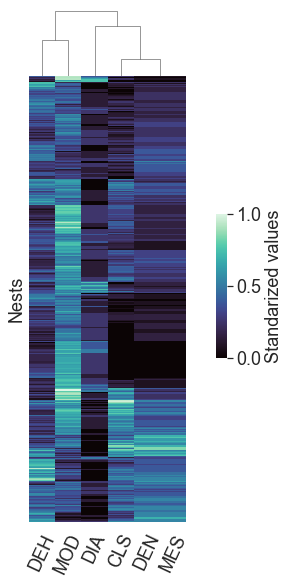

In [14]:
# Fontsize
fs =18

# Plot clustermap
cm = sns.clustermap(df_P,
                    col_linkage=linkage,
                    yticklabels=False,
                    cmap="mako",
                    cbar_kws={'ticks':[0, 0.5, 1]},
                    cbar_pos=(0.75, .38, .025, .25),
                    figsize =(6,8))

# Visual adjustments
hm = cm.ax_heatmap.get_position()

# Dendogram
cm.ax_row_dendrogram.remove()
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0 * 1.5, 
                                   hm.y0 * 1.7 + hm.height, 
                                   col.width * 0.5, 
                                   col.height * 0.85])

# Heatmap
cm.ax_heatmap.set_position([hm.x0 * 1.5, 
                            hm.y0 * 1.7, 
                            hm.width * 0.5, 
                            hm.height * 1.05])
cm.ax_heatmap.set_ylabel('Nests', fontsize=fs)
cm.ax_heatmap.yaxis.set_label_position("left")

# Colorbar
cm.ax_cbar.tick_params(labelsize=fs)
cm.ax_cbar.set_ylabel('Standardized values', size=fs)

# Rotate and fontsize of labels
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xticklabels(),rotation=65, fontsize=fs)

# Save picture
plt.savefig(name +'/plots/'+ 'clustermap', dpi=500)


## Correlation heatmap
In this section we calculate and visualise the pairwise Pearson correlations among the set of transmission properties. 

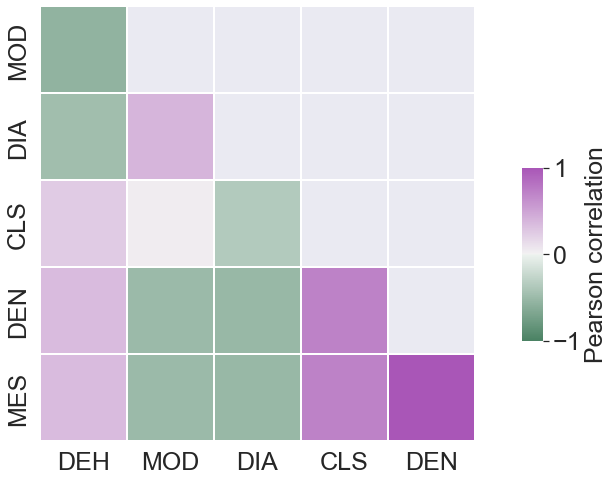

In [9]:
sns.set(rc={'figure.figsize':(10,8)})

fig, ax = plt.subplots(1, 1)

# Reorder columns to match the HCA order
df_P = df_P[[i.get_text() for i in cm.ax_heatmap.get_xticklabels()]]

cbar_ax = fig.add_axes([.88, .3, .03, .3])
corr = df_P.corr(method=metric).iloc[1:,:-1]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True


# Fontsize
fs = 25

# Plot correlation heatmap
with sns.axes_style("white"):
    hm = sns.heatmap(corr,
                    mask=mask,
                    center=0,
                    ax=ax,
                    vmax=1, vmin=-1,
                    linewidths=1.8,
                    square='True',
                    cbar_ax=cbar_ax,
                    cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
    
# Adjust labels fontsize
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs)
 
# Colorbar
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=fs)  
cbar.ax.set_ylabel('Pearson correlation', size=fs)
cbar.set_ticks([-1, 0, 1])
plt.savefig(name +'/plots/'+ 'correlation', dpi=500)
